In [8]:
import torch
print(torch.__version__)
import torch.nn as nn
import pandas as pd
from collections import Counter
import numpy as np
import torchvision
import torch.nn.functional as F

## This module provides tools to transform images, such as resizing, cropping, flipping, converting to tensors, and normalizing
import torchvision.transforms as transforms

#This is a dataset class that loads images from a directory structure where each folder is treated as a separate class.
#It automatically assigns labels based on subfolder names.
import torchvision.datasets as datasets


#This utility creates an iterable over the dataset, allowing for loading data in batches, shuffling, and parallel data loading with multiple workers.
from torch.utils.data import DataLoader

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
import torchvision.models as models
import copy
import random

# Import sklearn metrics for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Import visualization tools
import matplotlib.pyplot as plt
import seaborn as sns



2.5.0+cu121


In [9]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.4 MB/s eta 0:00:00


In [10]:
!pip install scikit-optimize skorch torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 15.9 MB/s eta 0:00:00


In [11]:
from torch.utils.data import DataLoader, random_split
# Set a fixed random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Additional settings for GPU reproducibility
#torch.cuda.manual_seed(seed)
#torch.cuda.manual_seed_all(seed)            # If using multiple GPUs
#torch.backends.cudnn.deterministic = True   # Ensures deterministic behavior for some GPU operations
#torch.backends.cudnn.benchmark = False      # Disables auto-tuning for determinism

In [12]:
# Define Cutout transformation
class Cutout:
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        h, w = img.size(1), img.size(2)
        mask = np.ones((h, w), np.float32)

        for _ in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.0

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img *= mask
        return img

# Define transformations for training, validation, and testing data
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),          # Random cropping with padding
    transforms.RandomHorizontalFlip(),             # Random horizontal flip
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Color Jitter
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)), # Normalize with CIFAR-10 stats
    Cutout(n_holes=1, length=8)                    # Cutout
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Split the training set into training and validation sets
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])



# Create DataLoaders for training, validation, and testing
train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=4)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=4)
test_loader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=4)


print(f"Number of training samples: {len(trainset)}")
print(f"Number of validation samples: {len(valset)}")
print(f"Number of test samples: {len(testset)}")

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Number of training samples: 40000
Number of validation samples: 10000
Number of test samples: 10000


In [19]:
# Define MobileNetV2 with configurable dropout
class MobileNetV2WithDropout(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super(MobileNetV2WithDropout, self).__init__()
        self.model = mobilenet_v2(pretrained=False)
        self.model.classifier[1] = nn.Linear(self.model.last_channel, 10)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.model.features(x)
        x = x.mean([2, 3])  # Global average pooling
        x = self.dropout(x)
        x = self.model.classifier(x)
        return x

# Training function
def train_one_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# Testing function
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = running_loss / total
    test_acc = 100. * correct / total
    return test_loss, test_acc, all_preds, all_labels


In [20]:
# Initialize model with default dropout probability for initial training
initial_dropout_prob = 0.2
model = MobileNetV2WithDropout(dropout_prob=initial_dropout_prob).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

# Initial Training with default batch size
initial_epochs = 10
for epoch in range(initial_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    scheduler.step()
    print(f"Initial Epoch [{epoch+1}/{initial_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Evaluate the model on the test set with default settings
test_loss, test_acc, all_preds, all_labels = test_model(model, test_loader, criterion)
print(f"Initial Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")


Initial Epoch [1/10], Train Loss: 2.2282, Train Acc: 19.96%, Val Loss: 2.0404, Val Acc: 26.03%
Initial Epoch [2/10], Train Loss: 2.0217, Train Acc: 29.04%, Val Loss: 1.9752, Val Acc: 32.15%
Initial Epoch [3/10], Train Loss: 1.9064, Train Acc: 34.47%, Val Loss: 1.8255, Val Acc: 37.71%
Initial Epoch [4/10], Train Loss: 1.8260, Train Acc: 38.16%, Val Loss: 1.7477, Val Acc: 41.84%
Initial Epoch [5/10], Train Loss: 1.7670, Train Acc: 41.41%, Val Loss: 1.7267, Val Acc: 42.66%
Initial Epoch [6/10], Train Loss: 1.7091, Train Acc: 43.74%, Val Loss: 1.6560, Val Acc: 45.74%
Initial Epoch [7/10], Train Loss: 1.6725, Train Acc: 45.84%, Val Loss: 1.6496, Val Acc: 46.53%
Initial Epoch [8/10], Train Loss: 1.6308, Train Acc: 48.27%, Val Loss: 1.5849, Val Acc: 49.88%
Initial Epoch [9/10], Train Loss: 1.5960, Train Acc: 49.62%, Val Loss: 1.5625, Val Acc: 51.31%
Initial Epoch [10/10], Train Loss: 1.5623, Train Acc: 51.48%, Val Loss: 1.5457, Val Acc: 51.96%
Initial Test Loss: 1.4606, Test Accuracy: 55.52%


In [21]:
# Define hyperparameters to tune
learning_rates = [0.1, 0.01, 0.001]
batch_sizes = [64, 128]
weight_decays = [1e-4, 5e-4]
dropouts = [0.2, 0.3]
num_epochs = 20
results = []
best_val_accuracy = 0

# Iterate over each combination of hyperparameters
for lr in learning_rates:
    for batch_size in batch_sizes:
        for weight_decay in weight_decays:
            for dropout_prob in dropouts:
                # Initialize model, criterion, optimizer, and scheduler
                model = MobileNetV2WithDropout(dropout_prob=dropout_prob).to(device)
                criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
                scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

                # Data loaders with current batch size
                train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
                val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

                for epoch in range(num_epochs):
                    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
                    val_loss, val_acc = validate(model, val_loader, criterion)
                    scheduler.step()

                    # Update best validation accuracy and hyperparameters
                    if val_acc > best_val_accuracy:
                        best_val_accuracy = val_acc
                        best_model = copy.deepcopy(model.state_dict())
                        best_hyperparams = {
                            'learning_rate': lr,
                            'batch_size': batch_size,
                            'weight_decay': weight_decay,
                            'dropout_prob': dropout_prob,
                        }

                # Record results
                results.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'weight_decay': weight_decay,
                    'dropout_prob': dropout_prob,
                    'val_accuracy': val_acc,
                })
                print(f"LR: {lr}, Batch: {batch_size}, WD: {weight_decay}, Dropout: {dropout_prob}, Val Acc: {val_acc:.2f}%")

# Print best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparams)
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")


LR: 0.1, Batch: 64, WD: 0.0001, Dropout: 0.2, Val Acc: 49.59%
LR: 0.1, Batch: 64, WD: 0.0001, Dropout: 0.3, Val Acc: 35.78%
LR: 0.1, Batch: 64, WD: 0.0005, Dropout: 0.2, Val Acc: 44.79%
LR: 0.1, Batch: 64, WD: 0.0005, Dropout: 0.3, Val Acc: 41.50%
LR: 0.1, Batch: 128, WD: 0.0001, Dropout: 0.2, Val Acc: 44.72%
LR: 0.1, Batch: 128, WD: 0.0001, Dropout: 0.3, Val Acc: 34.35%
LR: 0.1, Batch: 128, WD: 0.0005, Dropout: 0.2, Val Acc: 43.73%
LR: 0.1, Batch: 128, WD: 0.0005, Dropout: 0.3, Val Acc: 50.69%
LR: 0.01, Batch: 64, WD: 0.0001, Dropout: 0.2, Val Acc: 54.77%
LR: 0.01, Batch: 64, WD: 0.0001, Dropout: 0.3, Val Acc: 49.00%
LR: 0.01, Batch: 64, WD: 0.0005, Dropout: 0.2, Val Acc: 62.93%
LR: 0.01, Batch: 64, WD: 0.0005, Dropout: 0.3, Val Acc: 47.61%
LR: 0.01, Batch: 128, WD: 0.0001, Dropout: 0.2, Val Acc: 58.84%
LR: 0.01, Batch: 128, WD: 0.0001, Dropout: 0.3, Val Acc: 58.05%
LR: 0.01, Batch: 128, WD: 0.0005, Dropout: 0.2, Val Acc: 61.43%
LR: 0.01, Batch: 128, WD: 0.0005, Dropout: 0.3, Val Acc:

Test Loss with Optimized Hyperparameters: 1.2265, Test Accuracy: 67.04%
Classification Report (Optimized):
              precision    recall  f1-score   support

    airplane       0.66      0.74      0.70      1000
  automobile       0.80      0.86      0.83      1000
        bird       0.51      0.60      0.55      1000
         cat       0.48      0.45      0.46      1000
        deer       0.68      0.50      0.57      1000
         dog       0.59      0.54      0.57      1000
        frog       0.68      0.79      0.73      1000
       horse       0.72      0.73      0.72      1000
        ship       0.84      0.75      0.79      1000
       truck       0.77      0.75      0.76      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

Confusion Matrix (Optimized):


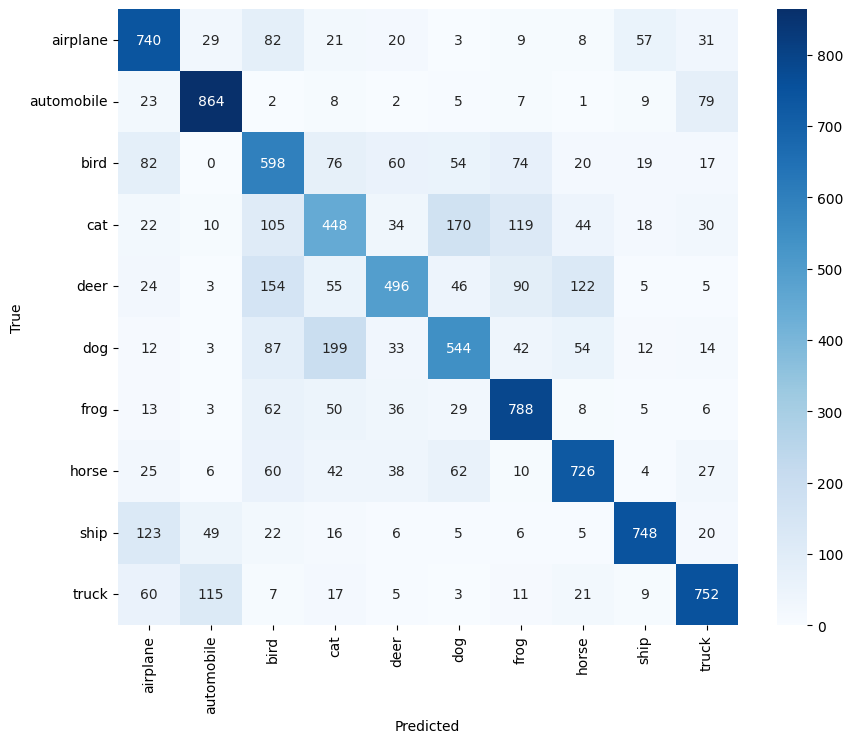

In [22]:
# Load the best model with optimized hyperparameters
model.load_state_dict(best_model)

# Prepare test loader with best batch size
test_loader = DataLoader(testset, batch_size=best_hyperparams['batch_size'], shuffle=False, num_workers=4)

# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_labels = test_model(model, test_loader, criterion)
print(f"Test Loss with Optimized Hyperparameters: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

# Classification report and confusion matrix
print("Classification Report (Optimized):")
print(classification_report(all_labels, all_preds, target_names=testset.classes))

print("Confusion Matrix (Optimized):")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=testset.classes, yticklabels=testset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
